# Credit Card Fraud with Machine Learning

The aim of this project is to build a classifier so that we can detect credit card fraudulent transaction. The dataset is obtained from: https://www.kaggle.com/mlg-ulb/creditcardfraud.

In [10]:
import os
import sys
import pandas
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

input_file = "./creditcard.csv"

# Data Exploration

The dataset consists of credit card transactions that features (V1, V2... Vx) are the product of PCA analysis. The only features that are non-PCA are **Time, Amount, Class**.

- Time: Seconds elapsed between each transaction and first transaction
- Class: Type of transaction (1 is fraud, 0 is valid)
- Amount: Transaction Amount

The purpose of this section is to understand the data so that we know how to proceed to the next step.

In [6]:
df = pandas.read_csv(input_file, header=0)

In [7]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df.isnull().values.any() # Nice, no missing value in this dataset

False

In [16]:
df["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [31]:
df["Time"].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

## How many transactions are labeled as fraud?

This seems like an imbalance dataset. With 492 fraud and 284315 valid transaction. This is highly imbalanced...

In [23]:
pd.value_counts(df["Class"])

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:>

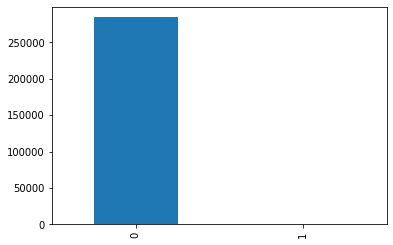

In [34]:
pd.value_counts(df["Class"]).plot.bar()

## What is the distribution of the other "known" features?

The distribution of the graphs show the following:

1) Amount is skewed --> potentially be biased?

2) Time is less skewed.

If the sample is unbalanced, this may cause overfitting. The model might assume for the most cases when the sample is heavily skewed on another end (mostly valid).

<AxesSubplot:ylabel='Frequency'>

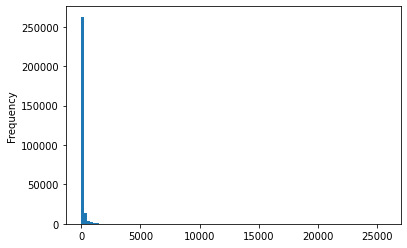

In [45]:
df["Amount"].sort_values().plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

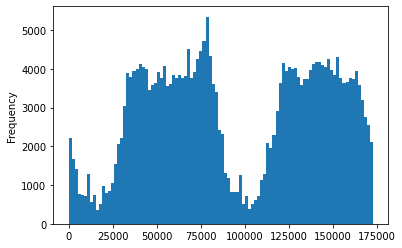

In [44]:
df["Time"].sort_values().plot.hist(bins=100)

## How are the amount distributed in the "fraud" cases?

<AxesSubplot:ylabel='Frequency'>

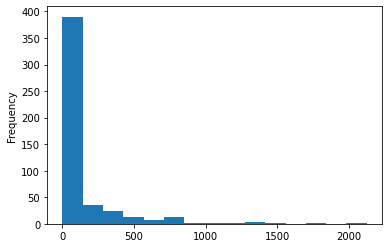

In [50]:
df[df["Class"] == 1]["Amount"].sort_values().plot.hist(bins=15)

## How are the amount distributed in the non-fraud cases?

<AxesSubplot:ylabel='Frequency'>

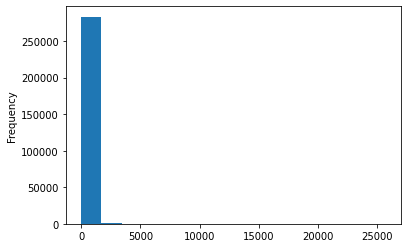

In [51]:
df[df["Class"] == 0]["Amount"].sort_values().plot.hist(bins=15)

# Dealing with Imbalanced Dataset

https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

- Resample the training set #1: Under-sampling (reduces the size of abundant class. Quantity of data is sufficient)
- Resample the training set #2: Over-sampling (increase the size of the rare samples)

In our case, I think it would be possible for us to use one of these techniques to resample the training set. I can first try to reduce the size of abundant class... so i will reduce the valid transaction to 492 samples so it's balance

In [56]:
resamples = df.sample(frac=1) # resample a fraction

In [57]:
fraud = resamples.loc[df["Class"] == 1] # take all the fraud transaction
non_fraud = resamples.loc[df["Class"] == 0][:492] # take 492 the non-fraud transaction

In [62]:
new_df = pd.concat([fraud, non_fraud])

<AxesSubplot:>

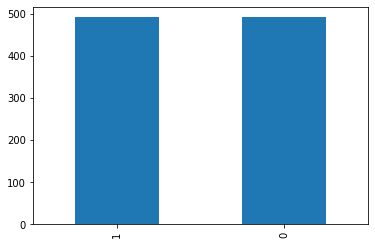

In [66]:
pd.value_counts(new_df["Class"]).plot.bar()

# Transform the Amount/Time

Since "Amount" and "Time" are not transformed, we will not be able to run any other stuffs beyond this.

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

resamples["scaled_amount"] = scaler.fit_transform(resamples["Amount"].values.reshape(-1, 1))
resamples["scaled_time"] = scaler.fit_transform(resamples["Time"].values.reshape(-1, 1))

In [74]:
resamples_scaled = resamples.drop(["Time", "Amount"], axis=1)

# Correlation Matrix

See if any features give a very strong influence to the fraud/valid transaction

<AxesSubplot:>

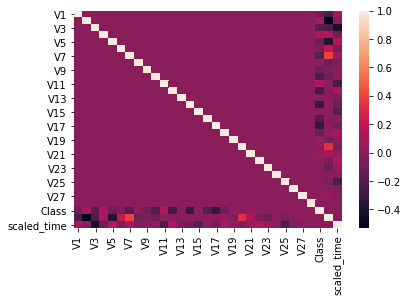

In [75]:
corr = resamples_scaled.corr()
sns.heatmap(corr)